In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr

In [2]:
files = [file for file in os.listdir('./parametros')]

param = pd.DataFrame()
for file in files:
  df = pd.read_csv('./parametros/'+file)
  param = pd.concat([param, df], axis= 0)

Revolviendo los datos

In [3]:
from sklearn.model_selection import train_test_split
param = param.sample(frac=1, random_state=42).reset_index(drop=True)
train_df, test_df = train_test_split(param, test_size=0.2, random_state=42)

Normalizando

# Ahora invertimos la red, de input será Fracción vol, espesor y radio. Output longitud de onda e Índice de absorción

Normalizacion

In [4]:
# Cargar DataFrame
df = train_df
# Separar datos de entrada y salida
Y = df[['Índice de absorción', 'Longitud de onda']]
X = df[['Fracvol', 'Radio (nm)', 'Espesor de la película (nm)']]

In [5]:
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X = scaler_X.fit_transform(X)
Y = scaler_Y.fit_transform(Y)

Esto se hace para poder ver los errores

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [7]:
# Creamos el modelo de la red neuronal
model = Sequential()
model.add(Dense(64, input_dim=3, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='linear'))

In [8]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [9]:
history = model.fit(X, Y, validation_data=(X_val, y_val),epochs=100, batch_size=10)

Epoch 1/100
3072/3072 [==============================] - 3s 680us/step - loss: 0.0453 - val_loss: 0.0448
Epoch 2/100
3072/3072 [==============================] - 2s 649us/step - loss: 0.0440 - val_loss: 0.0439
Epoch 3/100
3072/3072 [==============================] - 2s 658us/step - loss: 0.0439 - val_loss: 0.0437
Epoch 4/100
3072/3072 [==============================] - 2s 652us/step - loss: 0.0439 - val_loss: 0.0439
Epoch 5/100
3072/3072 [==============================] - 2s 649us/step - loss: 0.0439 - val_loss: 0.0437
Epoch 6/100
3072/3072 [==============================] - 2s 647us/step - loss: 0.0439 - val_loss: 0.0436
Epoch 7/100
3072/3072 [==============================] - 2s 634us/step - loss: 0.0438 - val_loss: 0.0435
Epoch 8/100
3072/3072 [==============================] - 2s 646us/step - loss: 0.0438 - val_loss: 0.0436
Epoch 9/100
3072/3072 [==============================] - 2s 643us/step - loss: 0.0438 - val_loss: 0.0436
Epoch 10/100
3072/3072 [==============================]

Normalizando los datos de test

In [10]:
x_pred = test_df[['Fracvol', 'Radio (nm)', 'Espesor de la película (nm)']]

In [11]:
y_normalized = scaler_Y.transform(test_df[['Índice de absorción', 'Longitud de onda']])

In [12]:
x_pred_norm = scaler_X.transform(x_pred) 
pred_norm = model.predict(x_pred_norm)

240/240 [==============================] - 0s 484us/step


In [13]:
test_loss = model.evaluate(x_pred_norm, y_normalized)
test_loss

240/240 [==============================] - 0s 625us/step - loss: 0.0434


0.04343103617429733

Calculando error cuadrático medio 

In [14]:
# Calcular error cuadrático medio (MSE) en los datos normalizados
mse = np.mean(np.square(y_normalized - pred_norm))
print("MSE: ", mse)

# Desnormalizar el MSE
mse_denormalized = scaler_Y.inverse_transform(np.array([[mse, 0]]))[0][0]
print("MSE desnormalizado: ", mse_denormalized)

MSE:  0.04343101952423982
MSE desnormalizado:  0.005999157463474531


In [23]:
# calcular MAE
mae = mean_absolute_error(y_normalized, pred_norm)

# calcular R
r, _ = pearsonr(y_normalized.flatten(), pred_norm.flatten())

# calcular R^2
r2 = r2_score(y_normalized, pred_norm)

print("MAE:", mae)
mae_denormalized = scaler_Y.inverse_transform(np.array([[mae, 0]]))[0][0]
print("MAE desnormalizado: ", mse_denormalized)
print("R:", r)
r_denormalized = scaler_Y.inverse_transform(np.array([[r, 0]]))[0][0]
print("R desnormalizado: ", r_denormalized)
print("R^2:", r2)
r2_denormalized = scaler_Y.inverse_transform(np.array([[r2, 0]]))[0][0]
print("R^2 desnormalizado: ", r2_denormalized)

MAE: 0.13659525746741777
MAE desnormalizado:  0.005999157463474531
R: 0.7511902360496036
R desnormalizado:  0.10376192924653053
R^2: 0.047102934559448306
R^2 desnormalizado:  0.006506359041655597


Gráfica de función de pérdida contra pérdida, para ver si se necesitan más épocas en el modelo

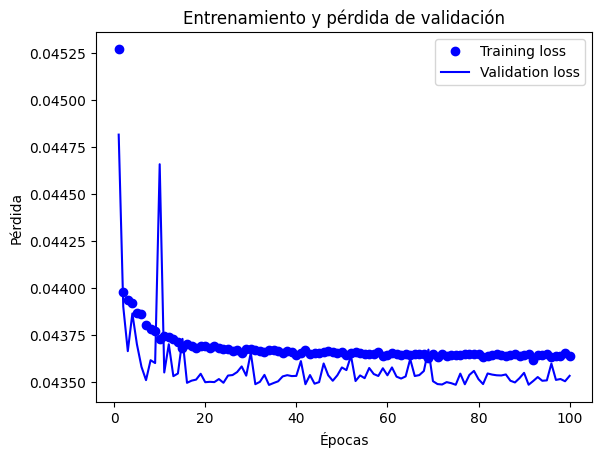

In [16]:
# Graficar la función de pérdida
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Entrenamiento y pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [17]:
pred = scaler_Y.inverse_transform(pred_norm)
pred

array([[5.2492791e-03, 6.0056403e+02],
       [1.6080502e-03, 6.0076923e+02],
       [1.6080502e-03, 6.0076923e+02],
       ...,
       [4.6214848e-03, 6.0059937e+02],
       [1.6080502e-03, 6.0076923e+02],
       [1.6080502e-03, 6.0076923e+02]], dtype=float32)

# Renombrando las columnas

In [26]:
predicciones = pd.DataFrame(pred)
predicciones.columns = ['Índice de absorción', 'Longitud de onda']


In [32]:
predicciones['Índice de absorción'].unique()

array([0.00524928, 0.00160805, 0.00901605, 0.00282775, 0.00838825,
       0.00776046, 0.00189643, 0.00306058, 0.01089943, 0.00650487,
       0.01215502, 0.00212926, 0.00462148, 0.00587707, 0.0016636 ,
       0.01027163, 0.00236209, 0.00345905, 0.00713266, 0.00964384,
       0.00259492, 0.01152722, 0.00964384, 0.00345905], dtype=float32)

In [33]:
predicciones['Longitud de onda'].unique()

array([600.564  , 600.7692 , 600.3516 , 600.7005 , 600.3871 , 600.4224 ,
       600.75305, 600.6874 , 600.2455 , 600.49316, 600.1747 , 600.73987,
       600.59937, 600.5286 , 600.7661 , 600.2809 , 600.72675, 600.6649 ,
       600.4578 , 600.3162 , 600.7136 , 600.21014], dtype=float32)

# Probando la accurancy del modelo

Primero lo haremos por cada parámetro. Se le restará los valores predichos por la red a los valores originales de test. Se contarán el número de ceros y ese será lo acertada que es nuestra red. De tener valores inferiores a 80% en número de ceros este rango se incrementará hasta llegar a un valor que el 80% de los valores sean menores a este

# Longitud de onda

In [19]:
redondeo = predicciones['Longitud de onda'].to_numpy()
test_df_long = test_df['Longitud de onda'].to_numpy()
dif = redondeo - test_df_long 
#count_nonzero() cuenta el número de elementos distintos de cero en el arreglo, mientras que la función size() devuelve el tamaño total del arreglo. 
total = dif.size
num_zeros = dif.size - np.count_nonzero(dif)
porcentaje = num_zeros*100/total
print("presición del ", porcentaje, "%.")

presición del  0.0 %.


In [20]:
# Se agrega umbral hasta llegar a 80% de aceptación
i = 0
while(porcentaje < 80):
    umbral = i
    num = np.count_nonzero(np.abs(dif) <= umbral)
    porcentaje = num*100/total
    print("presición del ", porcentaje, "%. Con el redondeo para arriba en espesor y un rango de", umbral)
    i = i + 1

presición del  0.0 %. Con el redondeo para arriba en espesor y un rango de 0
presición del  0.3645833333333333 %. Con el redondeo para arriba en espesor y un rango de 1
presición del  0.7682291666666666 %. Con el redondeo para arriba en espesor y un rango de 2
presición del  1.0286458333333333 %. Con el redondeo para arriba en espesor y un rango de 3
presición del  1.4453125 %. Con el redondeo para arriba en espesor y un rango de 4
presición del  1.8229166666666667 %. Con el redondeo para arriba en espesor y un rango de 5
presición del  2.1354166666666665 %. Con el redondeo para arriba en espesor y un rango de 6
presición del  2.4739583333333335 %. Con el redondeo para arriba en espesor y un rango de 7
presición del  2.9296875 %. Con el redondeo para arriba en espesor y un rango de 8
presición del  3.2291666666666665 %. Con el redondeo para arriba en espesor y un rango de 9
presición del  3.6328125 %. Con el redondeo para arriba en espesor y un rango de 10
presición del  3.984375 %. Co

In [21]:
redondeo = predicciones['Índice de absorción'].to_numpy()
test_df_long = test_df['Índice de absorción'].to_numpy()
dif = redondeo - test_df_long 
#count_nonzero() cuenta el número de elementos distintos de cero en el arreglo, mientras que la función size() devuelve el tamaño total del arreglo. 
total = dif.size
num_zeros = dif.size - np.count_nonzero(dif)
porcentaje = num_zeros*100/total
print("presición del ", porcentaje, "%.")

presición del  0.0 %.


In [22]:
# Se agrega umbral hasta llegar a 80% de aceptación
i = 0
while(porcentaje < 80):
    umbral = i
    num = np.count_nonzero(np.abs(dif) <= umbral)
    porcentaje = num*100/total
    print("presición del ", porcentaje, "%. Con el redondeo para arriba en espesor y un rango de", umbral)
    i = i + .001

presición del  0.0 %. Con el redondeo para arriba en espesor y un rango de 0
presición del  42.447916666666664 %. Con el redondeo para arriba en espesor y un rango de 0.001
presición del  67.44791666666667 %. Con el redondeo para arriba en espesor y un rango de 0.002
presición del  71.640625 %. Con el redondeo para arriba en espesor y un rango de 0.003
presición del  75.46875 %. Con el redondeo para arriba en espesor y un rango de 0.004
presición del  79.0625 %. Con el redondeo para arriba en espesor y un rango de 0.005
presición del  83.15104166666667 %. Con el redondeo para arriba en espesor y un rango de 0.006
